# Peter a vlk: Úvod do posilňovacieho učenia

V tomto tutoriáli sa naučíme, ako aplikovať posilňovacie učenie na problém hľadania cesty. Prostredie je inšpirované hudobnou rozprávkou [Peter a vlk](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) od ruského skladateľa [Sergeja Prokofieva](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Je to príbeh o mladom pionierovi Petrovi, ktorý odvážne opustí svoj dom a vydá sa na lesnú čistinu, aby prenasledoval vlka. Vytrénujeme algoritmy strojového učenia, ktoré Petrovi pomôžu preskúmať okolitú oblasť a vytvoriť optimálnu navigačnú mapu.

Najskôr si importujeme niekoľko užitočných knižníc:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Prehľad posilňovacieho učenia

**Posilňovacie učenie** (RL) je technika učenia, ktorá nám umožňuje naučiť sa optimálne správanie **agenta** v určitom **prostredí** prostredníctvom vykonávania mnohých experimentov. Agent v tomto prostredí by mal mať nejaký **cieľ**, definovaný pomocou **funkcie odmeny**.

## Prostredie

Pre zjednodušenie si predstavme Petrov svet ako štvorcovú dosku veľkosti `width` x `height`. Každé pole na tejto doske môže byť:
* **zem**, po ktorej Peter a ostatné bytosti môžu chodiť
* **voda**, po ktorej, samozrejme, nemôžete chodiť
* **strom** alebo **tráva** - miesto, kde si môžete oddýchnuť
* **jablko**, ktoré predstavuje niečo, čo by Peter rád našiel, aby sa nakŕmil
* **vlk**, ktorý je nebezpečný a treba sa mu vyhnúť

Na prácu s prostredím definujeme triedu nazvanú `Board`. Aby sme tento zápisník príliš nezahltili, presunuli sme všetok kód na prácu s doskou do samostatného modulu `rlboard`, ktorý teraz importujeme. Môžete sa pozrieť do tohto modulu, aby ste získali viac podrobností o interných častiach implementácie.


In [2]:
from rlboard import *

Poďme teraz vytvoriť náhodnú dosku a pozrieť sa, ako vyzerá:


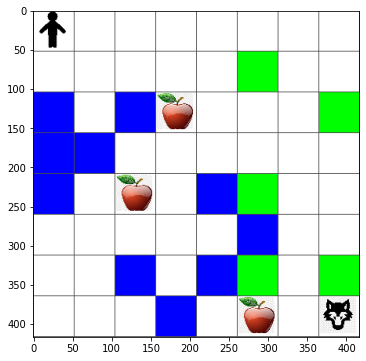

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Akcie a politika

V našom príklade by Peterovým cieľom bolo nájsť jablko, pričom sa vyhne vlkovi a ďalším prekážkam. Na dosiahnutie tohto cieľa môže v podstate chodiť, kým nenájde jablko. Preto si na každej pozícii môže vybrať jednu z nasledujúcich akcií: hore, dole, doľava a doprava. Tieto akcie definujeme ako slovník a priradíme ich k dvojiciam zodpovedajúcich zmien súradníc. Napríklad pohyb doprava (`R`) by zodpovedal dvojici `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Strategia nášho agenta (Petra) je definovaná takzvanou **politikou**. Pozrime sa na najjednoduchšiu politiku nazývanú **náhodná prechádzka**.

## Náhodná prechádzka

Najprv vyriešme náš problém implementáciou stratégie náhodnej prechádzky.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Poďme vykonať experiment náhodnej prechádzky niekoľkokrát a pozrieť sa na priemerný počet vykonaných krokov:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Funkcia odmeny

Aby sme našu politiku urobili inteligentnejšou, musíme pochopiť, ktoré ťahy sú „lepšie“ ako ostatné.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Vytvorte Q-Tabuľku alebo viacrozmerné pole. Keďže naša hracia plocha má rozmery `šírka` x `výška`, môžeme Q-Tabuľku reprezentovať ako numpy pole s tvarom `šírka` x `výška` x `len(akcie)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Preneste Q-Tabuľku do funkcie na vykreslenie, aby ste vizualizovali tabuľku na doske:


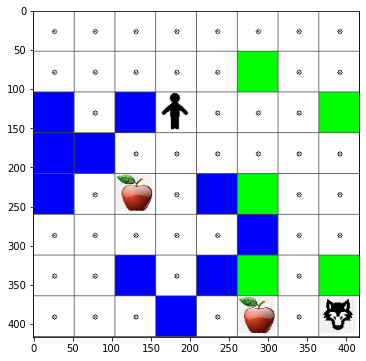

In [9]:
m.plot(Q)

## Podstata Q-Learning: Bellmanova rovnica a učebný algoritmus

Napíšte pseudokód pre náš učebný algoritmus:

* Inicializujte Q-Tabuľku Q rovnakými hodnotami pre všetky stavy a akcie
* Nastavte rýchlosť učenia $\alpha\leftarrow 1$
* Opakujte simuláciu mnohokrát
   1. Začnite na náhodnej pozícii
   1. Opakujte
        1. Vyberte akciu $a$ v stave $s$
        2. Vykonajte akciu presunutím do nového stavu $s'$
        3. Ak narazíme na podmienku konca hry alebo je celková odmena príliš malá - ukončite simuláciu  
        4. Vypočítajte odmenu $r$ v novom stave
        5. Aktualizujte Q-Funkciu podľa Bellmanovej rovnice: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Aktualizujte celkovú odmenu a znížte $\alpha$.

## Využívanie vs. Preskúmavanie

Najlepší prístup je nájsť rovnováhu medzi preskúmavaním a využívaním. Ako sa dozvedáme viac o našom prostredí, budeme pravdepodobne nasledovať optimálnu cestu, avšak občas si zvolíme nepreskúmanú cestu.

## Implementácia v Pythone

Teraz sme pripravení implementovať učebný algoritmus. Predtým však potrebujeme funkciu, ktorá premení ľubovoľné čísla v Q-Tabuľke na vektor pravdepodobností pre zodpovedajúce akcie:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Pridáme malé množstvo `eps` k pôvodnému vektoru, aby sme sa vyhli deleniu nulou v počiatočnom prípade, keď sú všetky komponenty vektora identické.

Skutočný učebný algoritmus budeme spúšťať počas 5000 experimentov, nazývaných aj **epochy**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Po vykonaní tohto algoritmu by mala byť Q-Tabuľka aktualizovaná hodnotami, ktoré definujú atraktivitu rôznych akcií v každom kroku. Vizualizujte tabuľku tu:


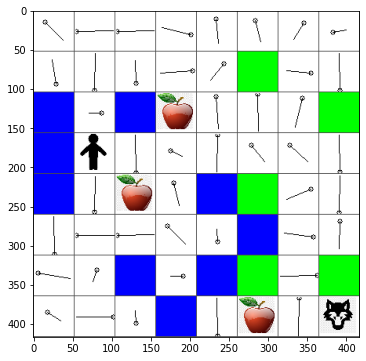

In [12]:
m.plot(Q)

## Kontrola politiky

Keďže Q-Tabuľka uvádza „atraktivitu“ každej akcie v každom stave, je pomerne jednoduché použiť ju na definovanie efektívnej navigácie v našom svete. V najjednoduchšom prípade môžeme jednoducho vybrať akciu zodpovedajúcu najvyššej hodnote v Q-Tabuľke:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Ak vyskúšate vyššie uvedený kód niekoľkokrát, môžete si všimnúť, že sa niekedy jednoducho "zasekne" a musíte stlačiť tlačidlo STOP v notebooku, aby ste ho prerušili.

> **Úloha 1:** Upraviť funkciu `walk` tak, aby obmedzila maximálnu dĺžku cesty na určitý počet krokov (napríklad 100), a sledovať, ako vyššie uvedený kód občas vráti túto hodnotu.

> **Úloha 2:** Upraviť funkciu `walk` tak, aby sa nevracala na miesta, kde už predtým bola. Tým sa zabráni tomu, aby sa `walk` dostal do slučky, avšak agent sa stále môže ocitnúť "uväznený" na mieste, z ktorého sa nedokáže dostať.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


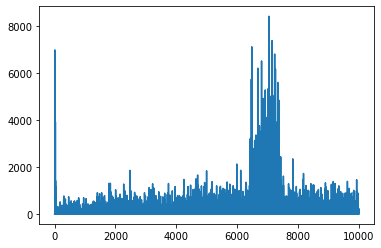

In [15]:
plt.plot(lpath)

To, čo tu vidíme, je, že na začiatku sa priemerná dĺžka cesty zvýšila. Pravdepodobne je to spôsobené tým, že keď o prostredí nič nevieme, máme tendenciu uviaznuť v zlých stavoch, ako je voda alebo vlk. Keď sa však začneme učiť a využívať získané poznatky, dokážeme prostredie skúmať dlhšie, no stále nevieme presne, kde sa nachádzajú jablká.

Keď sa naučíme dostatok informácií, agentovi sa cieľ dosahuje ľahšie a dĺžka cesty sa začne skracovať. Napriek tomu sme stále otvorení skúmaniu, takže často odbočíme z najlepšej cesty a skúmame nové možnosti, čo spôsobí, že cesta je dlhšia, než by bola optimálna.

Na grafe tiež pozorujeme, že v určitom bode sa dĺžka náhle zvýšila. To poukazuje na stochastickú povahu procesu a na to, že v určitom momente môžeme „pokaziť“ koeficienty Q-Tabuľky tým, že ich prepíšeme novými hodnotami. Ideálne by sa tomu malo predísť znižovaním rýchlosti učenia (t.j. ku koncu tréningu upravujeme hodnoty Q-Tabuľky len o malé hodnoty).

Celkovo je dôležité pamätať na to, že úspech a kvalita procesu učenia výrazne závisí od parametrov, ako sú rýchlosť učenia, pokles rýchlosti učenia a diskontný faktor. Tieto parametre sa často nazývajú **hyperparametre**, aby sa odlíšili od **parametrov**, ktoré optimalizujeme počas tréningu (napr. koeficienty Q-Tabuľky). Proces hľadania najlepších hodnôt hyperparametrov sa nazýva **optimalizácia hyperparametrov** a zaslúži si samostatnú tému.


## Cvičenie
#### Realistickejší svet Petra a vlka

V našej situácii sa Peter mohol pohybovať takmer bez toho, aby sa unavil alebo vyhladol. V realistickejšom svete si však musí z času na čas sadnúť a oddýchnuť si, a tiež sa najesť. Urobme náš svet realistickejším zavedením nasledujúcich pravidiel:

1. Pri presune z jedného miesta na druhé Peter stráca **energiu** a získava **únavu**.
2. Peter môže získať viac energie jedením jabĺk.
3. Peter sa môže zbaviť únavy odpočinkom pod stromom alebo na tráve (t. j. vstupom na políčko s umiestneným stromom alebo trávou - zelené pole).
4. Peter musí nájsť a zabiť vlka.
5. Aby Peter dokázal zabiť vlka, musí mať určitú úroveň energie a únavy, inak prehrá boj.

Upravte funkciu odmeny podľa pravidiel hry, spustite algoritmus posilňovaného učenia na naučenie najlepšej stratégie na výhru v hre a porovnajte výsledky náhodného pohybu s vaším algoritmom z hľadiska počtu vyhraných a prehratých hier.

> **Poznámka**: Možno bude potrebné upraviť hyperparametre, aby to fungovalo, najmä počet epoch. Keďže úspech v hre (boj s vlkom) je zriedkavá udalosť, môžete očakávať oveľa dlhší čas trénovania.



---

**Upozornenie**:  
Tento dokument bol preložený pomocou služby na automatický preklad [Co-op Translator](https://github.com/Azure/co-op-translator). Hoci sa snažíme o presnosť, upozorňujeme, že automatické preklady môžu obsahovať chyby alebo nepresnosti. Pôvodný dokument v jeho pôvodnom jazyku by mal byť považovaný za autoritatívny zdroj. Pre dôležité informácie odporúčame profesionálny ľudský preklad. Nezodpovedáme za akékoľvek nedorozumenia alebo nesprávne interpretácie vyplývajúce z použitia tohto prekladu.
